# USADS 508 W4

In [ ]:
!python --version
!pip list
# Pip
!pip install --disable-pip-version-check -q pip --upgrade > /dev/null
!pip install --disable-pip-version-check -q wrapt --upgrade > /dev/null
# AWS CLI and AWS Python SDK (boto3)
!pip install --disable-pip-version-check -q awscli==1.18.216 boto3==1.16.56 botocore==1.19.56
# SageMaker
!pip install --disable-pip-version-check -q sagemaker==2.29.0
!pip install --disable-pip-version-check -q smdebug==1.0.1
!pip install --disable-pip-version-check -q sagemaker-experiments==0.1.26
# PyTorch
!conda install -y pytorch==1.6.0 -c pytorch
# TensorFlow
!pip install --disable-pip-version-check -q tensorflow==2.3.1
# Hugging Face Transformers (BERT)
!pip install --disable-pip-version-check -q transformers==3.5.1
# TorchServe
!pip install --disable-pip-version-check -q torchserve==0.3.0
!pip install --disable-pip-version-check -q torch-model-archiver==0.3.0
# PyAthena
!pip install --disable-pip-version-check -q PyAthena==2.1.0
# Redshift
!pip install --disable-pip-version-check -q SQLAlchemy==1.3.22
# AWS Data Wrangler
!pip install --disable-pip-version-check -q awswrangler==2.3.0
# StepFunctions
!pip install --disable-pip-version-check -q stepfunctions==2.0.0rc1
# Zip
!conda install -y zip
# Matplotlib
!pip install --disable-pip-version-check -q matplotlib==3.1.3
# Seaborn
!pip install --disable-pip-version-check -q seaborn==0.10.0


# Summarize
!python --version
# !pip list
setup_dependencies_passed = True
%store setup_dependencies_passed
%store

In [2]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
import io
import sagemaker
from sagemaker import get_execution_role
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
from pyathena import connect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, \
RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report
from sagemaker.tuner import HyperparameterTuner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import loguniform
import warnings
warnings.filterwarnings('ignore')

# Section 1: Basic set up

#### Check the Environment was Created Correctly

In [3]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [4]:
import json

notebook_instance_name = None

try:
    with open("/opt/ml/metadata/resource-metadata.json") as notebook_info:
        data = json.load(notebook_info)
        domain_id = data["DomainId"]
        resource_arn = data["ResourceArn"]
        region = resource_arn.split(":")[3]
        name = data["ResourceName"]
    print("DomainId: {}".format(domain_id))
    print("Name: {}".format(name))
except:
    print("+++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR]: COULD NOT RETRIEVE THE METADATA.")
    print("+++++++++++++++++++++++++++++++++++++++++")

DomainId: d-7v61k0r2izyh
Name: datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395


In [5]:
describe_domain_response = sm.describe_domain(DomainId=domain_id)
print(describe_domain_response["Status"])

InService


In [6]:
try:
    get_status_response = sm.get_sagemaker_servicecatalog_portfolio_status()
    print(get_status_response["Status"])
except:
    pass

Enabled


In [7]:
if (
    describe_domain_response["Status"] == "InService"
    and get_status_response["Status"] == "Enabled"
    and "datascience" in name
):
    setup_instance_check_passed = True
    print("[OK] Checks passed!  Great Job!!  Please Continue.")
else:
    setup_instance_check_passed = False
    print("+++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR]: WE HAVE IDENTIFIED A MISCONFIGURATION.")
    print(describe_domain_response["Status"])
    print(get_status_response["Status"])
    print(name)
    print("+++++++++++++++++++++++++++++++++++++++++++++++")

[OK] Checks passed!  Great Job!!  Please Continue.


#### Update IAM Roles and Policies

In [8]:
import boto3
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

#### Get SageMaker Execution Role Name

In [9]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


#### Pre-Requisite: SageMaker notebook instance ExecutionRole contains IAMFullAccess Policy.

In [10]:
admin = False
post_policies = iam.list_attached_role_policies(RoleName=role_name)["AttachedPolicies"]
for post_policy in post_policies:
    if post_policy["PolicyName"] == "AdministratorAccess":
        admin = True
        break

setup_iam_roles_passed = True
print("[OK] You are all set up to continue with this workshop!")

[OK] You are all set up to continue with this workshop!


#### Check Pre-Requisites

In [11]:
if not setup_instance_check_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

#### Create Athena Database Schema

In [12]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = 'usd508team2'
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

#### Import PyAthena

In [13]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

#### Create Athena Database

In [14]:
database_name = "CA_Traffic"

In [15]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [16]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [17]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS CA_Traffic


In [18]:
import pandas as pd

pd.read_sql(statement, conn)

""


#### Verify The Database Has Been Created Succesfully

In [19]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,ca_traffic
1,default


In [20]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

#### Create Athena Table

In [21]:
# Set Athena parameters
database_name = "ca_traffic"
Ex_Ln_table = "Ex_Ln"
HOV_table = "HOV"
vol_table = "vol"
Route77_table = 'Route77'
s3_path_Ex_Ln = "s3://{}/Express_Lanes.csv".format(bucket)
s3_path_HOV = "s3://{}/HOV.csv".format(bucket)
s3_path_vol = "s3://{}/Traffic_Volumes_AADT.csv".format(bucket)
s3_path_Route77 = "s3://{}/Route_77.csv".format(bucket)

In [22]:
statement1 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID int,
         District int,
         Route string,
         Direction string,
         Begin_County string,
         Begin_Post_Mile string,
         End_County string,
         End_Post_Mile string,
         Begin_Abs_Post_Mile int,
         End_Abs_Post_Mile int,
         Description string,
         Length__Lane_Miles_ int,
         Opening_Date string,
         Occupancy_Requirement_for_Toll_ string,
         Hours_of_Operation string,
         Comments string,
         Shape_Length int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, Ex_Ln_table, s3_path_Ex_Ln
)

pd.read_sql(statement1, conn)

""


In [23]:
statement2 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID int,
         District int,
         Route string,
         Direction string,
         Begin_County string,
         Begin_Post_Mile string,
         End_County string,
         End_Post_Mile string,
         Begin_Abs_Post_Mile int,
         End_Abs_Post_Mile int,
         Description string,
         Length__Lane_Miles_ int,
         Occupancy_Requirement string,
         Hours_of_Operation string,
         Segment_Opening_Date string,
         Comments string,
         Shape_Length int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, HOV_table, s3_path_HOV
)

pd.read_sql(statement2, conn)

""


In [24]:
statement3 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID int,
         District int,
         Route int,       
         RTE_SFX string,      
         COUNTY string,
         PM_PFX string, 
         PM int,
         PM_SFX string,
         DESCRIPTION string,
         BACK_PEAK_HOUR int,
         BACK_PEAK_MADT int,
         BACK_AADT int,
         AHEAD_PEAK_HOUR int,
         AHEAD_PEAK_MADT int,
         AHEAD_AADT int   
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, vol_table, s3_path_vol
)

pd.read_sql(statement3, conn)

""


In [25]:
statement4 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Date DATE,
         Day string,
         Lane string,
         Date_Time TIMESTAMP,
         Time TIMESTAMP,      
         Minimum int,
         Mean int, 
         Maximum int,
         Lane_Pts_num int,
         Oberserved_percent int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, Route77_table, s3_path_Route77
)

pd.read_sql(statement4, conn)

""


#### check if all the table been created succeffully 

In [26]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,ex_ln
1,hov
2,route77
3,traffic_volumes_aadt
4,vol


# Section 2: Exploratory Data Analysis (EDA)

#### Ex_Ln Table:

In [27]:
Ex_Ln_df = pd.read_csv(s3_path_Ex_Ln)
Ex_Ln_df.info()
Ex_Ln_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OBJECTID                         27 non-null     int64  
 1   District                         27 non-null     int64  
 2   Route                            27 non-null     object 
 3   Direction                        27 non-null     object 
 4   Begin_County                     27 non-null     object 
 5   Begin_Post_Mile                  27 non-null     object 
 6   End_County                       27 non-null     object 
 7   End_Post_Mile                    27 non-null     object 
 8   Begin_Abs_Post_Mile              27 non-null     float64
 9   End_Abs_Post_Mile                27 non-null     float64
 10  Description                      27 non-null     object 
 11  Length__Lane_Miles_              27 non-null     float64
 12  Opening_Date            

,OBJECTID,District,Route,Direction,Begin_County,Begin_Post_Mile,End_County,End_Post_Mile,Begin_Abs_Post_Mile,End_Abs_Post_Mile,Description,Length__Lane_Miles_,Opening_Date,Occupancy_Requirement_for_Toll_,Hours_of_Operation,Comments,Shape_Length
0,1,4,237,EB,SCL,R3.343,SCL,R9.164R,3.400,9.216,Mathilda Avenue to I-880,7.316,Mathilda Ave. to Zanker Rd. - 11/15/2019; Zank...,3+,M-F; 05:00-20:00,Conversion from HOV to Express Lane. ; Mileage...,11502.249796
1,2,4,580,EB,ALA,18.913,ALA,R8.762,35.097,24.916,Hacienda Rd to Greenville Rd,17.041,2/19/2016,2+,M-F; 05:00-20:00,Converted from HOV lane. Includes dual lane se...,20683.777789
2,3,7,10S,EB,LA,16.968,LA,27.96,0.000,10.992,Alameda St to Baldwin Ave,17.022,Alameda St to Mission Rd - Apr 1990; Mission R...,3+ 5:00-9:00 am M-F; 3+ 4:00-7:00 pm M-F; 2+ A...,24 hrs,Mileage includes dual lane segment from PM 22....,21359.741104
3,4,7,10,EB,LA,27.963,LA,30.995,26.463,29.495,Baldwin Ave to I-605,5.273,Baldwin Ave to Rte 605 � Feb 2005; Converted t...,3+ 5:00-9:00 am M-F; 3+ 4:00-7:00 pm M-F; 2+ A...,24 hrs,Mileage includes dual lane segment from PM 27....,5877.568529
4,5,8,91,EB,RIV,R0.000,RIV,7.514,37.232,44.858,Orange County Line to I-15,16.524,Converted from single lane HOV lane to dual Ex...,3+; (Pay 50% discounted toll Monday thru Frida...,24 hrs,; Dual lane facility from PM R0.000 to PM 6.41...,14765.391421


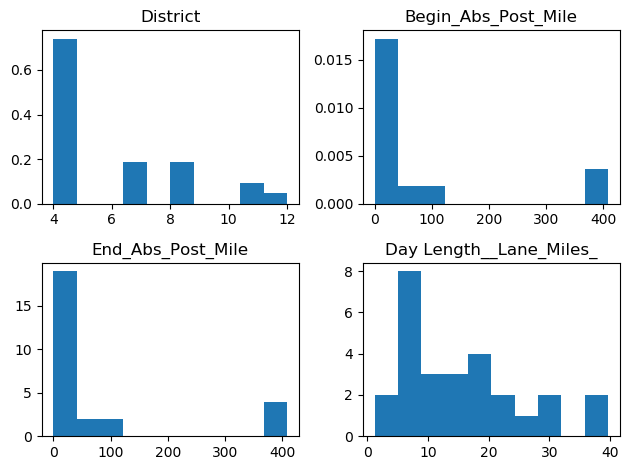

In [28]:
n_bins = 10
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

ax0.hist(Ex_Ln_df['District'], n_bins, density=True, histtype='bar', stacked = True)
ax0.set_title('District')

ax1.hist(Ex_Ln_df['Begin_Abs_Post_Mile'], n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('Begin_Abs_Post_Mile')

ax2.hist(Ex_Ln_df['End_Abs_Post_Mile'], n_bins, histtype='bar', stacked=True)
ax2.set_title('End_Abs_Post_Mile')

ax3.hist(Ex_Ln_df['Length__Lane_Miles_'], n_bins, histtype='bar', stacked=True)
ax3.set_title('Day Length__Lane_Miles_')


fig.tight_layout()
plt.show()

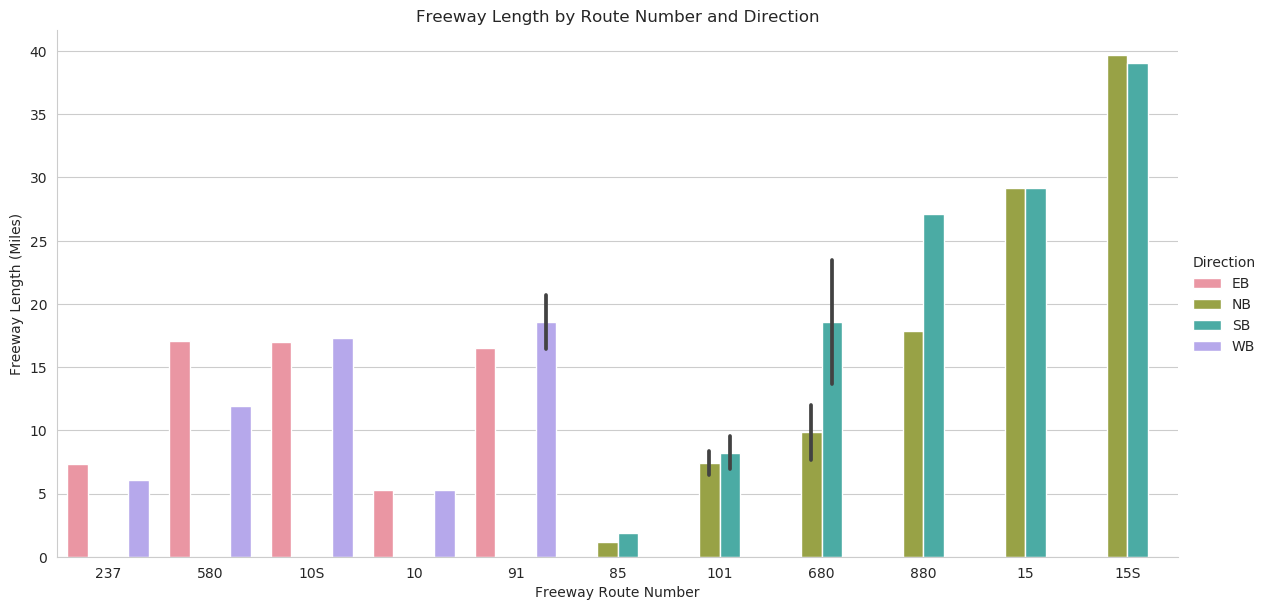

In [29]:
# Create a grouped bar chart using seaborn
sns.set_style("whitegrid")
sns.set_palette("husl", 2)
ax = sns.catplot(x='Route', y='Length__Lane_Miles_', hue='Direction', 
                 kind='bar', data=Ex_Ln_df, height = 6, aspect=2)

# Set the axis labels and title
ax.set_xlabels('Freeway Route Number')
ax.set_ylabels('Freeway Length (Miles)')
ax.set(title='Freeway Length by Route Number and Direction')

# Show the plot
plt.show()

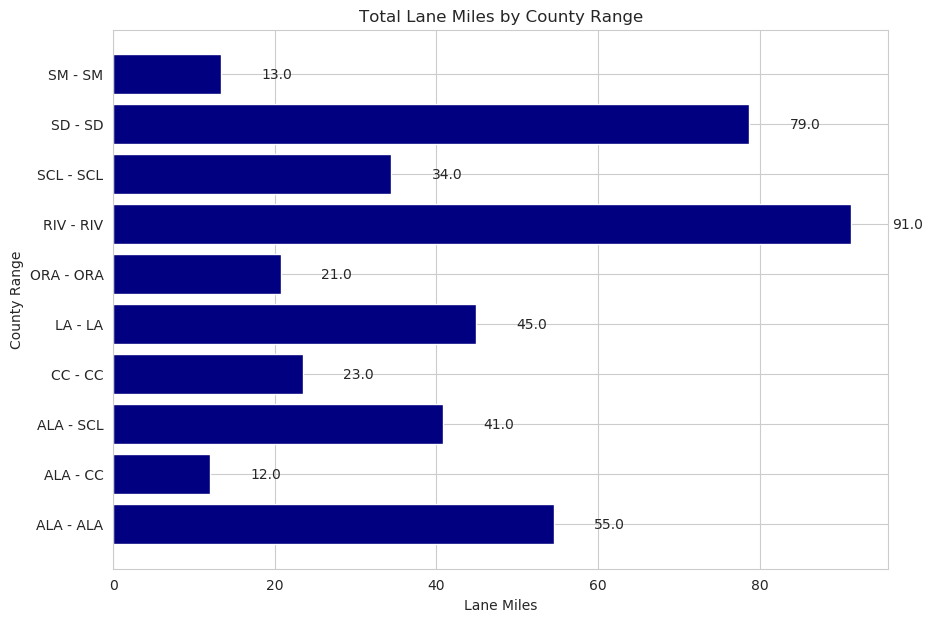

In [30]:
# Group the data by county and sum the lane miles
grouped_data = Ex_Ln_df.groupby(['Begin_County', 'End_County']).agg({'Length__Lane_Miles_': 'sum'}).reset_index()

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(y=grouped_data['Begin_County'] + ' - ' + grouped_data['End_County'], width=grouped_data['Length__Lane_Miles_'], color='navy')

# Set the axis labels and title
ax.set_xlabel('Lane Miles')
ax.set_ylabel('County Range')
ax.set_title('Total Lane Miles by County Range')

# Add labels to the bars
for i, bar in enumerate(bars):
    value = bar.get_width()
    x_pos = value + 5
    y_pos = i
    ax.text(x_pos, y_pos, str(round(value)), va='center')

# Show the plot
plt.show()

#### HOV Dataset:

In [31]:
HOV_df = pd.read_csv(s3_path_HOV)
HOV_df.info()
HOV_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OBJECTID               109 non-null    int64  
 1   District               109 non-null    int64  
 2   Route                  109 non-null    object 
 3   Direction              109 non-null    object 
 4   Begin_County           109 non-null    object 
 5   Begin_Post_Mile        109 non-null    object 
 6   End_County             109 non-null    object 
 7   End_Post_Mile          109 non-null    object 
 8   Begin_Abs_Post_Mile    106 non-null    float64
 9   End_Abs_Post_Mile      106 non-null    float64
 10  Description            109 non-null    object 
 11  Length__Lane_Miles_    109 non-null    float64
 12  Occupancy_Requirement  109 non-null    object 
 13  Hours_of_Operation     109 non-null    object 
 14  Segment_Opening_Date   105 non-null    object 
 15  Commen

,OBJECTID,District,Route,Direction,Begin_County,Begin_Post_Mile,End_County,End_Post_Mile,Begin_Abs_Post_Mile,End_Abs_Post_Mile,Description,Length__Lane_Miles_,Occupancy_Requirement,Hours_of_Operation,Segment_Opening_Date,Comments,Shape_Length
0,1,3,50,EB,SAC,R5.371,ED,5.834,11.005,34.632,Watt Ave to Cameron Park Dr,23.627,2+,M-F 06:00-10:00 and 15:00-19:00,Watt Ave to Sunrise Blvd - Dec 2011; Sunrise B...,NaN,48659.155980
1,2,3,80,EB,SAC,M0.767,PLA,4.718,84.691,106.237,West El Camino Ave to SR-65,21.546,2+,M-F 06:00-10:00 and 15:00-19:00,Yolo Co Line to Longview Dr - Dec 2016; Longvi...,NaN,44432.185806
2,3,4,80,EB,SOL,0.504,SOL,0.673,27.995,28.164,Carquinez Bridge Toll Plaza,0.255,3+,M-F 05:00-10:00 and 15:00-19:00,"Opened; W/O Toll Plaza to E/O Toll Plaza, 07/3...",2-Seat Vehicles with 2 Persons Permitted; Toll...,348.131415
3,4,4,80,EB,SOL,R11.485,SOL,19.594,38.976,47.096,Red Top Road to Air Base Pkwy,8.120,2+,M-F 05:00-10:00 and 15:00-19:00,"Opened; Red Top Road to E/O Air Base Pkwy., 11...",NaN,16660.846138
4,5,7,10,EB,LA,30.995,LA,48.265,29.495,46.765,I-605 to San Bernardino County Line,17.270,2+,24 Hr,Rte 605 to 0.6 mi west of Puente Ave (Francisq...,Continues into San Bernardino County,33527.727027


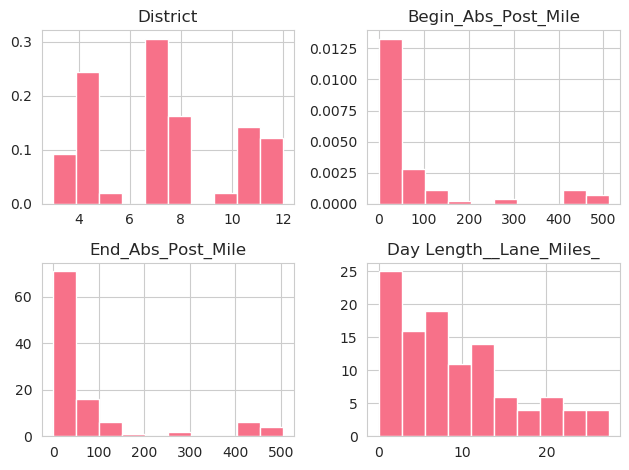

In [32]:
n_bins = 10
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

ax0.hist(HOV_df['District'], n_bins, density=True, histtype='bar', stacked = True)
ax0.set_title('District')

ax1.hist(HOV_df['Begin_Abs_Post_Mile'], n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('Begin_Abs_Post_Mile')

ax2.hist(HOV_df['End_Abs_Post_Mile'], n_bins, histtype='bar', stacked=True)
ax2.set_title('End_Abs_Post_Mile')

ax3.hist(HOV_df['Length__Lane_Miles_'], n_bins, histtype='bar', stacked=True)
ax3.set_title('Day Length__Lane_Miles_')

fig.tight_layout()
plt.show()

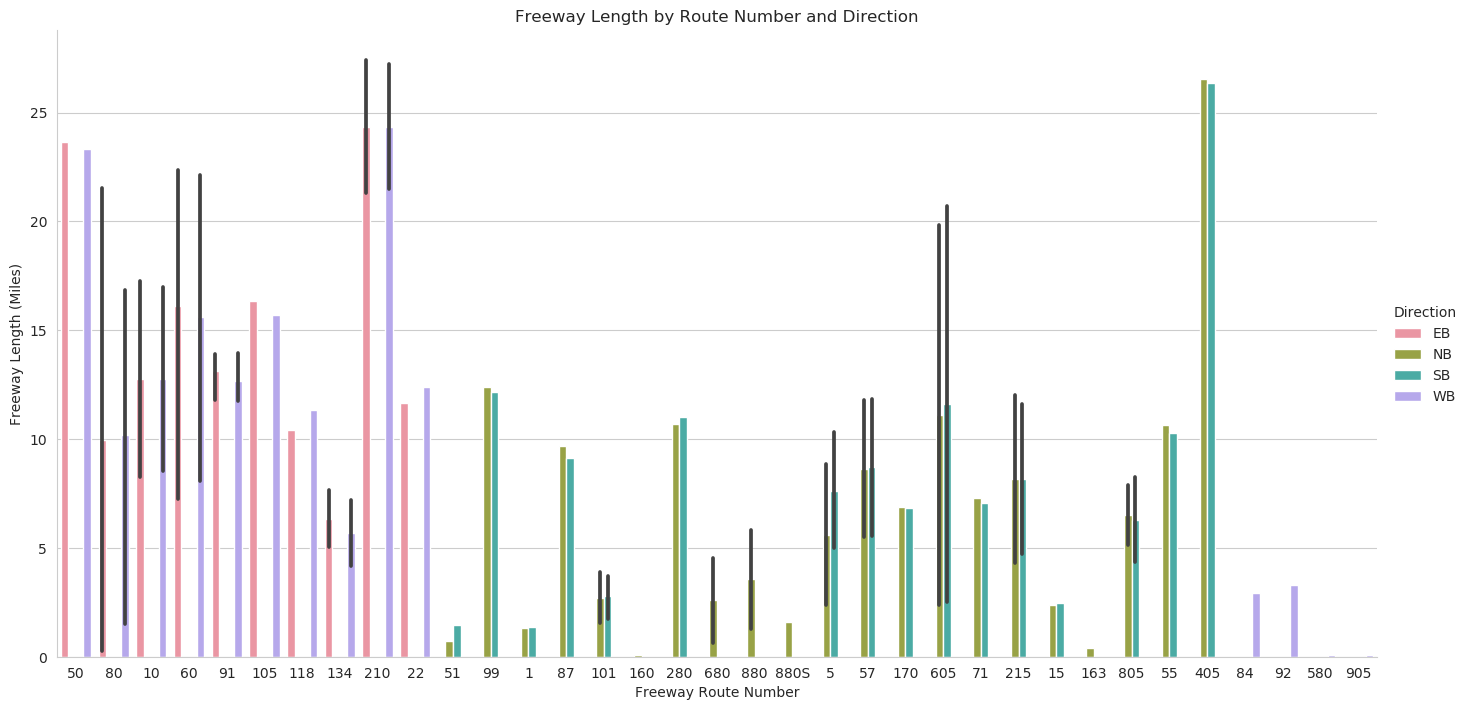

In [33]:
# Create a grouped bar chart using seaborn
sns.set_style("whitegrid")
sns.set_palette("husl", 2)
ax = sns.catplot(x='Route', y='Length__Lane_Miles_', hue='Direction', 
                 kind='bar', data=HOV_df, height = 7, aspect=2)

# Set the axis labels and title
ax.set_xlabels('Freeway Route Number')
ax.set_ylabels('Freeway Length (Miles)')
ax.set(title='Freeway Length by Route Number and Direction')

# Show the plot
plt.show()

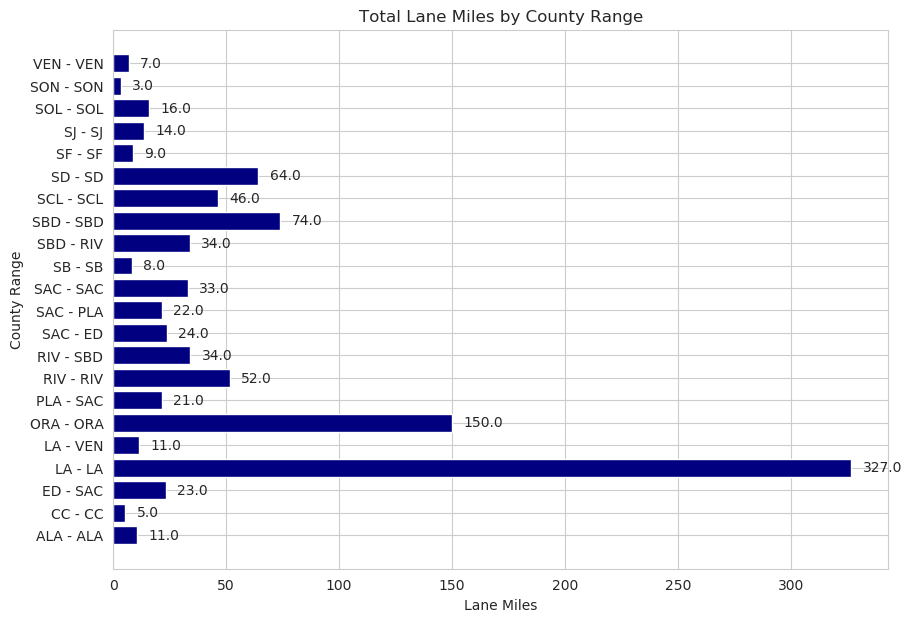

In [34]:
# Group the data by county and sum the lane miles
grouped_data = HOV_df.groupby(['Begin_County', 'End_County']).agg({'Length__Lane_Miles_': 'sum'}).reset_index()

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(y=grouped_data['Begin_County'] + ' - ' + grouped_data['End_County'], width=grouped_data['Length__Lane_Miles_'], color='navy')

# Set the axis labels and title
ax.set_xlabel('Lane Miles')
ax.set_ylabel('County Range')
ax.set_title('Total Lane Miles by County Range')

# Add labels to the bars
for i, bar in enumerate(bars):
    value = bar.get_width()
    x_pos = value + 5
    y_pos = i
    ax.text(x_pos, y_pos, str(round(value)), va='center')

# Show the plot
plt.show()

#### Traffic Volumes_AADT table:

In [35]:
vol_df = pd.read_csv(s3_path_vol)
vol_df.info()
vol_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7114 entries, 0 to 7113
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   OBJECTID         7114 non-null   int64  
 1   DISTRICT         7113 non-null   float64
 2   ROUTE            7114 non-null   int64  
 3   RTE_SFX          42 non-null     object 
 4   COUNTY           7114 non-null   object 
 5   PM_PFX           2367 non-null   object 
 6   PM               7114 non-null   float64
 7   PM_SFX           369 non-null    object 
 8   DESCRIPTION      7114 non-null   object 
 9   BACK_PEAK_HOUR   6471 non-null   float64
 10  BACK_PEAK_MADT   6471 non-null   float64
 11  BACK_AADT        6471 non-null   float64
 12  AHEAD_PEAK_HOUR  6483 non-null   float64
 13  AHEAD_PEAK_MADT  6483 non-null   float64
 14  AHEAD_AADT       6483 non-null   float64
dtypes: float64(8), int64(2), object(5)
memory usage: 833.8+ KB


,OBJECTID,DISTRICT,ROUTE,RTE_SFX,COUNTY,PM_PFX,PM,PM_SFX,DESCRIPTION,BACK_PEAK_HOUR,BACK_PEAK_MADT,BACK_AADT,AHEAD_PEAK_HOUR,AHEAD_PEAK_MADT,AHEAD_AADT
0,1,12.0,1,NaN,ORA,R,0.129,NaN,"DANA POINT, JCT. RTE. 5",NaN,NaN,NaN,4250.0,42000.0,38250.0
1,2,12.0,1,NaN,ORA,R,0.780,NaN,"DANA POINT, DOHENY PARK ROAD",4250.0,42000.0,38900.0,4350.0,43500.0,38900.0
2,3,12.0,1,NaN,ORA,R,1.077,NaN,BREAK IN RTE,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12.0,1,NaN,ORA,NaN,8.430,NaN,"LAGUNA BEACH, MOUNTAIN ROAD",3200.0,40500.0,37900.0,3200.0,40500.0,37900.0
4,5,12.0,1,NaN,ORA,NaN,9.418,NaN,"LAGUNA BEACH, JCT. RTE. 133 NORTH",3400.0,43000.0,38800.0,3850.0,43000.0,38800.0


In [36]:
grouped_data = vol_df.groupby('ROUTE').mean().reset_index()
grouped_data_back = grouped_data[['ROUTE', 'BACK_PEAK_HOUR','BACK_AADT']]
grouped_data_back['Rate'] = (grouped_data_back['BACK_PEAK_HOUR'] / grouped_data_back['BACK_AADT']) * 100
grouped_data_back = grouped_data_back.sort_values( "Rate", ascending = False).head(10)
grouped_data_back.style.background_gradient(cmap="Blues")
grouped_data_back

,ROUTE,BACK_PEAK_HOUR,BACK_AADT,Rate
187,220,474.000000,322.000000,147.204969
178,207,300.000000,740.000000,40.540541
120,136,80.000000,280.000000,28.571429
225,284,100.000000,370.000000,27.027027
217,270,120.000000,450.000000,26.666667
214,266,40.000000,160.000000,25.000000
206,254,263.333333,1106.666667,23.795181
146,167,20.000000,90.000000,22.222222
131,150,1967.333333,9116.666667,21.579525
138,158,255.000000,1187.500000,21.473684


In [37]:
grouped_data_ahead = grouped_data[['ROUTE', 'AHEAD_PEAK_HOUR','AHEAD_AADT']]
grouped_data_ahead['Rate'] = (grouped_data_ahead['AHEAD_PEAK_HOUR'] / grouped_data_ahead['AHEAD_AADT']) * 100
grouped_data_ahead = grouped_data_ahead.sort_values( "Rate", ascending = False).head(10)
grouped_data_ahead.style.background_gradient(cmap="Blues")
grouped_data_ahead

,ROUTE,AHEAD_PEAK_HOUR,AHEAD_AADT,Rate
217,270,90.000000,210.000000,42.857143
178,207,300.000000,750.000000,40.000000
192,229,60.000000,170.000000,35.294118
214,266,75.000000,215.000000,34.883721
84,95,718.000000,2685.000000,26.741155
187,220,76.000000,322.000000,23.602484
85,96,272.727273,1155.681818,23.598820
138,158,315.000000,1342.500000,23.463687
225,284,150.000000,660.000000,22.727273
218,271,51.428571,226.428571,22.712934


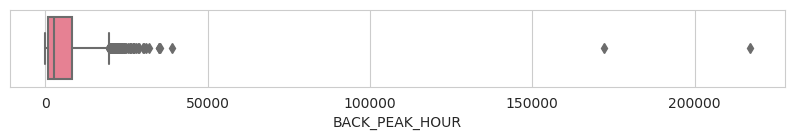

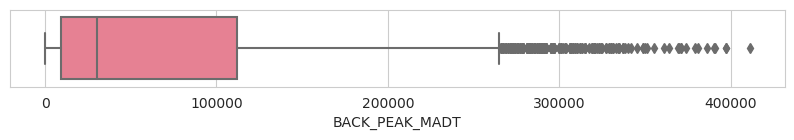

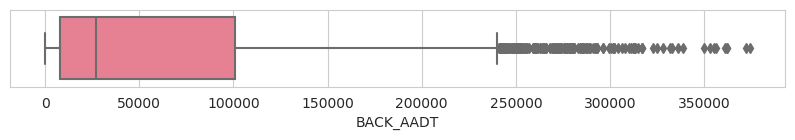

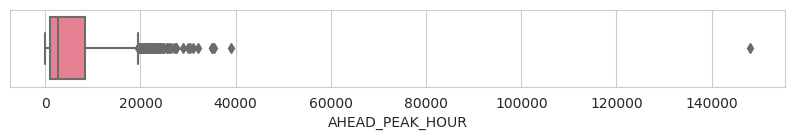

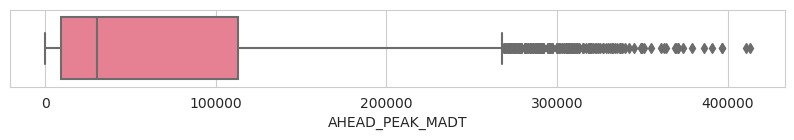

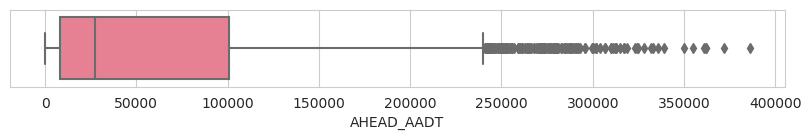

In [38]:
fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.BACK_PEAK_HOUR)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.BACK_PEAK_MADT)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.BACK_AADT)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.AHEAD_PEAK_HOUR)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.AHEAD_PEAK_MADT)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.AHEAD_AADT)

#### Route_77 Table

In [39]:
route77_df = pd.read_csv(s3_path_Route77)
route77_df = pd.DataFrame(route77_df)
route77_df.info()
route77_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                10080 non-null  object 
 1   Day                 10080 non-null  object 
 2   Lane                10080 non-null  object 
 3   Date_Time           10080 non-null  object 
 4   Time                10080 non-null  object 
 5   Minimum             10080 non-null  float64
 6   Mean                10080 non-null  float64
 7   Maximum             10080 non-null  float64
 8   Lane_Pts_num        10080 non-null  int64  
 9   Oberserved_percent  10080 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 787.6+ KB


,Date,Day,Lane,Date_Time,Time,Minimum,Mean,Maximum,Lane_Pts_num,Oberserved_percent
0,3/5/23,Sunday,Lane1,3/5/23 0:00,0:00:00,30.37,30.37,30.37,318,38.7
1,3/5/23,Sunday,Lane1,3/5/23 0:05,0:05:00,30.40,30.40,30.40,318,39.3
2,3/5/23,Sunday,Lane1,3/5/23 0:10,0:10:00,30.45,30.45,30.45,317,39.1
3,3/5/23,Sunday,Lane1,3/5/23 0:15,0:15:00,30.52,30.52,30.52,317,38.8
4,3/5/23,Sunday,Lane1,3/5/23 0:20,0:20:00,30.40,30.40,30.40,318,39.3


In [40]:
# Add the needed columns for better visualization, and transform the data type.
route77_df['Date_Time'] = pd.to_datetime(route77_df['Date_Time'])
route77_df['dt'] = pd.to_datetime(route77_df['Date_Time'])
route77_df['dt'] = route77_df['dt'].dt.date
route77_df['time_s']  = route77_df['Date_Time'].dt.time
route77_df

,Date,Day,Lane,Date_Time,Time,Minimum,Mean,Maximum,Lane_Pts_num,Oberserved_percent,dt,time_s
0,3/5/23,Sunday,Lane1,2023-03-05 00:00:00,0:00:00,30.37,30.37,30.37,318,38.7,2023-03-05,00:00:00
1,3/5/23,Sunday,Lane1,2023-03-05 00:05:00,0:05:00,30.40,30.40,30.40,318,39.3,2023-03-05,00:05:00
2,3/5/23,Sunday,Lane1,2023-03-05 00:10:00,0:10:00,30.45,30.45,30.45,317,39.1,2023-03-05,00:10:00
3,3/5/23,Sunday,Lane1,2023-03-05 00:15:00,0:15:00,30.52,30.52,30.52,317,38.8,2023-03-05,00:15:00
4,3/5/23,Sunday,Lane1,2023-03-05 00:20:00,0:20:00,30.40,30.40,30.40,318,39.3,2023-03-05,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...
10075,3/11/23,Saturday,HOV,2023-03-11 23:35:00,23:35:00,31.30,31.30,31.30,316,5.1,2023-03-11,23:35:00
10076,3/11/23,Saturday,HOV,2023-03-11 23:40:00,23:40:00,31.25,31.25,31.25,317,5.0,2023-03-11,23:40:00
10077,3/11/23,Saturday,HOV,2023-03-11 23:45:00,23:45:00,31.23,31.23,31.23,316,5.1,2023-03-11,23:45:00
10078,3/11/23,Saturday,HOV,2023-03-11 23:50:00,23:50:00,31.27,31.27,31.27,317,5.0,2023-03-11,23:50:00


In [41]:
route77_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                10080 non-null  object        
 1   Day                 10080 non-null  object        
 2   Lane                10080 non-null  object        
 3   Date_Time           10080 non-null  datetime64[ns]
 4   Time                10080 non-null  object        
 5   Minimum             10080 non-null  float64       
 6   Mean                10080 non-null  float64       
 7   Maximum             10080 non-null  float64       
 8   Lane_Pts_num        10080 non-null  int64         
 9   Oberserved_percent  10080 non-null  float64       
 10  dt                  10080 non-null  object        
 11  time_s              10080 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 945.1+ KB


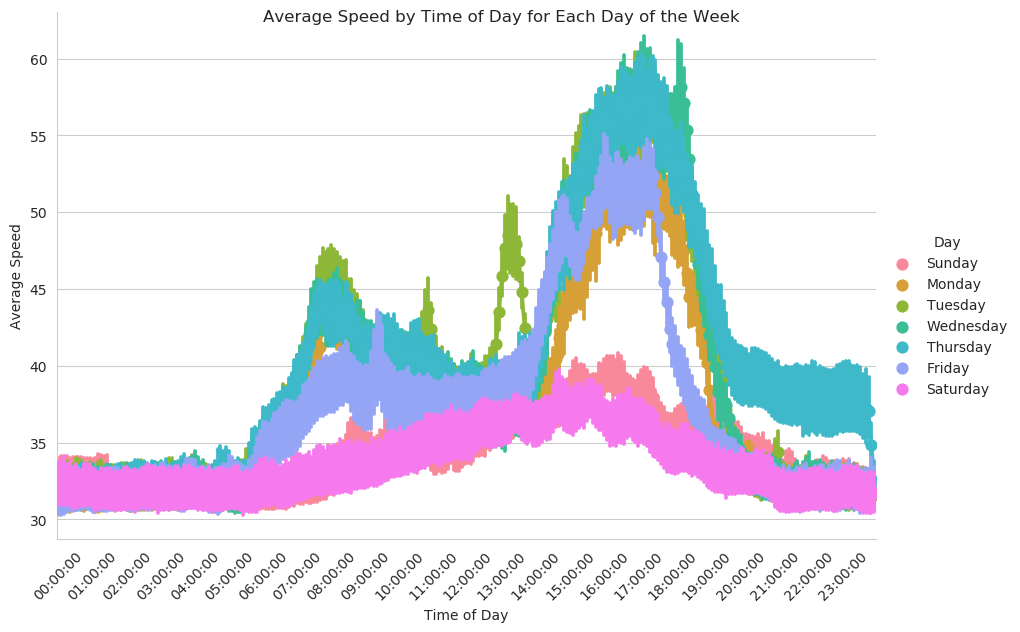

In [42]:
import matplotlib.ticker as ticker 

sns.set_style("whitegrid")
g = sns.catplot(x="time_s", y="Mean", hue="Day", data=route77_df, kind="point", height=6, aspect=1.5)

g.set_xlabels("Time of Day")
g.set_ylabels("Average Speed")
plt.xticks(rotation=45)
g.fig.suptitle("Average Speed by Time of Day for Each Day of the Week")

ax = g.facet_axis(0,0)   
every_nth = 12
for i, label in enumerate(ax.get_xticklabels()):
    if i % every_nth != 0:
        label.set_visible(False)    
    
plt.show()

# Section 3: Preparation:

#### Correlation Matrix:

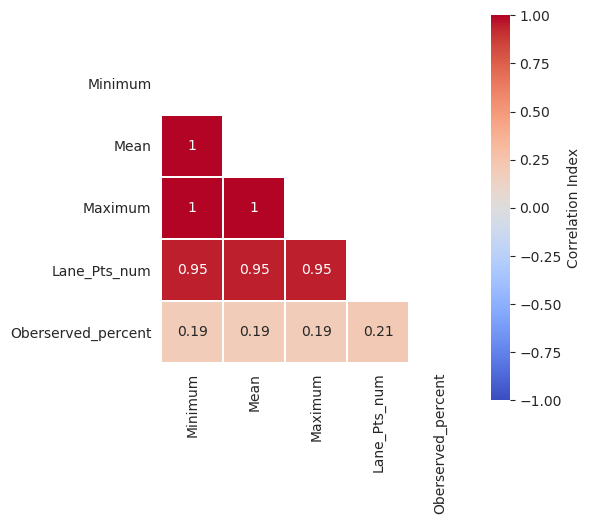

In [43]:
# assign correlation function to new variable
corr = route77_df.corr()
matrix = np.triu(corr) # for triangular matrix
plt.figure(figsize=(5,5))
# parse corr variable intro triangular matrix
sns.heatmap(route77_df.corr(method='pearson'), 
            annot=True, linewidths=.5, 
            cmap="coolwarm", mask=matrix,
            square = True, 
            cbar_kws={'label': 'Correlation Index'}, 
            vmin=-1, vmax=1)
plt.show()

##### The min and max values are highly correlated with the mean value; we will remove these two columns for our future analysis.
##### The last two columns are not for the speed-overserved rate, which is unrelated as well; we will remove these two as well.

In [44]:
# create a new table to store the needed data
route = pd.DataFrame([route77_df.dt, route77_df.Day,route77_df.Lane,route77_df.Mean,route77_df.time_s]).transpose()
route.head(5)

,dt,Day,Lane,Mean,time_s
0,2023-03-05,Sunday,Lane1,30.37,00:00:00
1,2023-03-05,Sunday,Lane1,30.40,00:05:00
2,2023-03-05,Sunday,Lane1,30.45,00:10:00
3,2023-03-05,Sunday,Lane1,30.52,00:15:00
4,2023-03-05,Sunday,Lane1,30.40,00:20:00


#### Feature Engineering

In [45]:
route['dt'] = pd.to_datetime(route['dt'])
# route['time_s'] = pd.to_datetime(route['time_s'])
route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      10080 non-null  datetime64[ns]
 1   Day     10080 non-null  object        
 2   Lane    10080 non-null  object        
 3   Mean    10080 non-null  object        
 4   time_s  10080 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 393.9+ KB


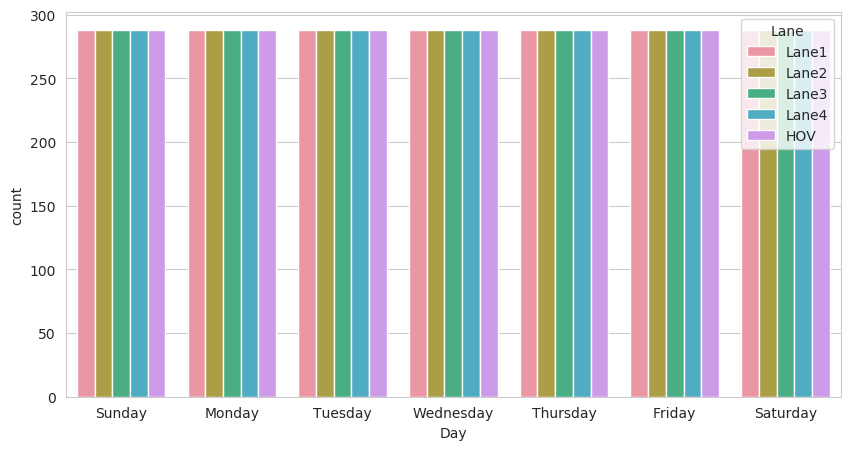

In [46]:
plt.figure(figsize=(10,5))
sns.countplot(data=route, x="Day", hue="Lane")
plt.show()

#### There is no need to balance the data at this point

#### Let's split the HOV data and non-HOV data

In [47]:
hov_df = route[route['Lane'] == 'HOV']
hov_df

,dt,Day,Lane,Mean,time_s
1152,2023-03-05,Sunday,HOV,31.95,00:00:00
1153,2023-03-05,Sunday,HOV,31.97,00:05:00
1154,2023-03-05,Sunday,HOV,32.00,00:10:00
1155,2023-03-05,Sunday,HOV,32.03,00:15:00
1156,2023-03-05,Sunday,HOV,31.93,00:20:00
...,...,...,...,...,...
10075,2023-03-11,Saturday,HOV,31.30,23:35:00
10076,2023-03-11,Saturday,HOV,31.25,23:40:00
10077,2023-03-11,Saturday,HOV,31.23,23:45:00
10078,2023-03-11,Saturday,HOV,31.27,23:50:00


In [48]:
lan_df = route[route['Lane'] != 'HOV']
lan_df

,dt,Day,Lane,Mean,time_s
0,2023-03-05,Sunday,Lane1,30.37,00:00:00
1,2023-03-05,Sunday,Lane1,30.40,00:05:00
2,2023-03-05,Sunday,Lane1,30.45,00:10:00
3,2023-03-05,Sunday,Lane1,30.52,00:15:00
4,2023-03-05,Sunday,Lane1,30.40,00:20:00
...,...,...,...,...,...
9787,2023-03-11,Saturday,Lane4,34.02,23:35:00
9788,2023-03-11,Saturday,Lane4,34.05,23:40:00
9789,2023-03-11,Saturday,Lane4,34.05,23:45:00
9790,2023-03-11,Saturday,Lane4,34.10,23:50:00


#### HOV data has only 2016 rows, and non-HOV data has 8064 rows. Let's merge them by the 'Day' and 'time_s'

In [49]:
merged_df = pd.merge(hov_df, lan_df, on=[ 'Day','time_s'])
merged_df

,dt_x,Day,Lane_x,Mean_x,time_s,dt_y,Lane_y,Mean_y
0,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane1,30.37
1,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane2,31.43
2,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane3,34.08
3,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane4,34.85
4,2023-03-05,Sunday,HOV,31.97,00:05:00,2023-03-05,Lane1,30.40
...,...,...,...,...,...,...,...,...
8059,2023-03-11,Saturday,HOV,31.27,23:50:00,2023-03-11,Lane4,34.10
8060,2023-03-11,Saturday,HOV,31.32,23:55:00,2023-03-11,Lane1,29.60
8061,2023-03-11,Saturday,HOV,31.32,23:55:00,2023-03-11,Lane2,30.95
8062,2023-03-11,Saturday,HOV,31.32,23:55:00,2023-03-11,Lane3,32.57


#### One-Hotot encoding
#### Create dummy variable

In [50]:
dummies = pd.get_dummies(merged_df[['Lane_y', 'Day', 'time_s']])
new_dum = pd.concat([merged_df, dummies], axis=1)

# drop the original 'Lane' and 'Day_of_Week' columns
new_dum.drop(['Lane_y', 'Day','time_s'], axis=1, inplace=True)

# print the resulting dataframe
print(new_dum)

           dt_x Lane_x Mean_x       dt_y Mean_y  Lane_y_Lane1  Lane_y_Lane2  \
0    2023-03-05    HOV  31.95 2023-03-05  30.37             1             0   
1    2023-03-05    HOV  31.95 2023-03-05  31.43             0             1   
2    2023-03-05    HOV  31.95 2023-03-05  34.08             0             0   
3    2023-03-05    HOV  31.95 2023-03-05  34.85             0             0   
4    2023-03-05    HOV  31.97 2023-03-05  30.40             1             0   
...         ...    ...    ...        ...    ...           ...           ...   
8059 2023-03-11    HOV  31.27 2023-03-11  34.10             0             0   
8060 2023-03-11    HOV  31.32 2023-03-11  29.60             1             0   
8061 2023-03-11    HOV  31.32 2023-03-11  30.95             0             1   
8062 2023-03-11    HOV  31.32 2023-03-11  32.57             0             0   
8063 2023-03-11    HOV  31.32 2023-03-11  34.28             0             0   

      Lane_y_Lane3  Lane_y_Lane4  Day_Friday  ...  

#### new_dum table is what we will use for the modeling, we will store it into the S3 bucket

In [51]:
from io import StringIO
# Convert the DataFrame to a CSV string
csv_buffer = StringIO()
new_dum.to_csv(csv_buffer, index=False)

# Upload the CSV string to the S3 bucket
s3_resource = boto3.resource('s3')
bucket_name = 'usd508team2'
file_key = 'new_dum.csv'
s3_resource.Object(bucket_name, file_key).put(Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': '89A9PF8BX3QB8Q2E',
  'HostId': 'p0w7uCel8YU9IwEBgoUdzu7sMohEHBLg2hCWTneYREX7t+7Eo1U5o3cndWS7YqpRuthh3PhGCPg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'p0w7uCel8YU9IwEBgoUdzu7sMohEHBLg2hCWTneYREX7t+7Eo1U5o3cndWS7YqpRuthh3PhGCPg=',
   'x-amz-request-id': '89A9PF8BX3QB8Q2E',
   'date': 'Mon, 27 Mar 2023 19:53:53 GMT',
   'x-amz-version-id': '.Ee30LGqtK.DEYV971TnawOHuqn_KEOQ',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"5c9930e4527720f80841cda986442c58"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5c9930e4527720f80841cda986442c58"',
 'ServerSideEncryption': 'AES256',
 'VersionId': '.Ee30LGqtK.DEYV971TnawOHuqn_KEOQ'}

In [52]:
CA_dir = 's3://usd508team2/'
s3_client = boto3.client("s3")
BUCKET='usd508team2'
# List all objects in the bucket
response = s3_client.list_objects(Bucket=BUCKET)

# Print the key names
for obj in response['Contents']:
    print(obj['Key'])

Express_Lanes.csv
HOV.csv
Route_77.csv
Traffic_Volumes_AADT.csv
athena/staging/002c9c1f-9c35-403f-85cb-042ae3aca772.txt
athena/staging/002c9c1f-9c35-403f-85cb-042ae3aca772.txt.metadata
athena/staging/00663255-087e-4063-a8f0-8f45960d2f7c.txt
athena/staging/00663255-087e-4063-a8f0-8f45960d2f7c.txt.metadata
athena/staging/034b1420-00e0-418f-b6e4-72cc6a040177.txt
athena/staging/034b1420-00e0-418f-b6e4-72cc6a040177.txt.metadata
athena/staging/04080688-9f17-45e9-bf31-6824496b3e79.txt
athena/staging/06717bf8-c00b-48af-9ff3-d810721cd453.txt
athena/staging/06717bf8-c00b-48af-9ff3-d810721cd453.txt.metadata
athena/staging/07168bb2-b153-4d16-906d-b23a7e50f636.txt
athena/staging/07168bb2-b153-4d16-906d-b23a7e50f636.txt.metadata
athena/staging/07b700c4-0c48-4b8c-ac41-82146e86c7df.txt
athena/staging/07b700c4-0c48-4b8c-ac41-82146e86c7df.txt.metadata
athena/staging/08b0ccd8-3cf2-45f4-aa19-56562e5f5a41.txt
athena/staging/08b0ccd8-3cf2-45f4-aa19-56562e5f5a41.txt.metadata
athena/staging/0b18c414-f77e-4d71

#### Now, the 'new_dum.csv' is in our S3 bucket

# Section 4: Modeling

In [53]:
# Get the variable list and remove the target variable and irrelevant columns
column_names = list(new_dum.columns)
column_names.remove('dt_x')
column_names.remove('Lane_x')
column_names.remove('Mean_x')
column_names.remove('dt_y')
# Print the list of column names
print(column_names)

['Mean_y', 'Lane_y_Lane1', 'Lane_y_Lane2', 'Lane_y_Lane3', 'Lane_y_Lane4', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'time_s_00:00:00', 'time_s_00:05:00', 'time_s_00:10:00', 'time_s_00:15:00', 'time_s_00:20:00', 'time_s_00:25:00', 'time_s_00:30:00', 'time_s_00:35:00', 'time_s_00:40:00', 'time_s_00:45:00', 'time_s_00:50:00', 'time_s_00:55:00', 'time_s_01:00:00', 'time_s_01:05:00', 'time_s_01:10:00', 'time_s_01:15:00', 'time_s_01:20:00', 'time_s_01:25:00', 'time_s_01:30:00', 'time_s_01:35:00', 'time_s_01:40:00', 'time_s_01:45:00', 'time_s_01:50:00', 'time_s_01:55:00', 'time_s_02:00:00', 'time_s_02:05:00', 'time_s_02:10:00', 'time_s_02:15:00', 'time_s_02:20:00', 'time_s_02:25:00', 'time_s_02:30:00', 'time_s_02:35:00', 'time_s_02:40:00', 'time_s_02:45:00', 'time_s_02:50:00', 'time_s_02:55:00', 'time_s_03:00:00', 'time_s_03:05:00', 'time_s_03:10:00', 'time_s_03:15:00', 'time_s_03:20:00', 'time_s_03:25:00', 'time_s_03:30:00', 't

In [54]:
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

X = new_dum[column_names]
Y = new_dum['Mean_x']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [55]:
print("x_train:",x_train.shape)
print("x_test:",x_test.shape)
print("y_train:",y_train.shape[0])
print("y_test:",y_test.shape[0])

x_train: (6451, 300)
x_test: (1613, 300)
y_train: 6451
y_test: 1613


#### LinearRegression model prediction

In [56]:
from sklearn.linear_model import LinearRegression
# Train a linear regression model on the training set
regressor = LinearRegression()
# Fit the regressor with the training data
regressor.fit(x_train, y_train)
# Predict the values for the test set
y_pred = regressor.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.8525872352074951


In [58]:
from sklearn.metrics import r2_score
Accuracy_lr=r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy_lr)

 Accuracy of the model is 97.51


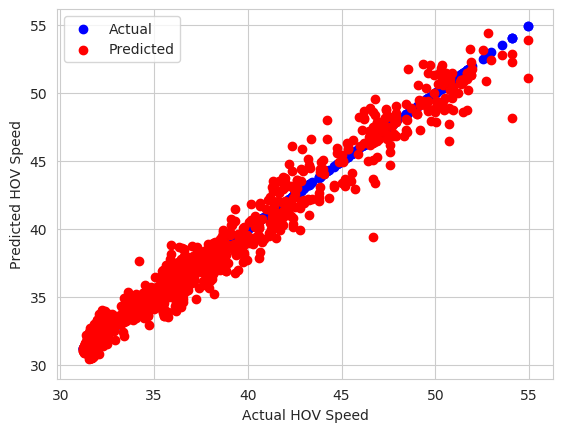

In [59]:
# Plot the actual values
plt.scatter(y_test, y_test, color='blue', label='Actual')

# Plot the predicted values
plt.scatter(y_test, y_pred, color='red', label='Predicted')

# Set the axis labels and legend
plt.xlabel('Actual HOV Speed')
plt.ylabel('Predicted HOV Speed')
plt.legend()

# Show the plot
plt.show()

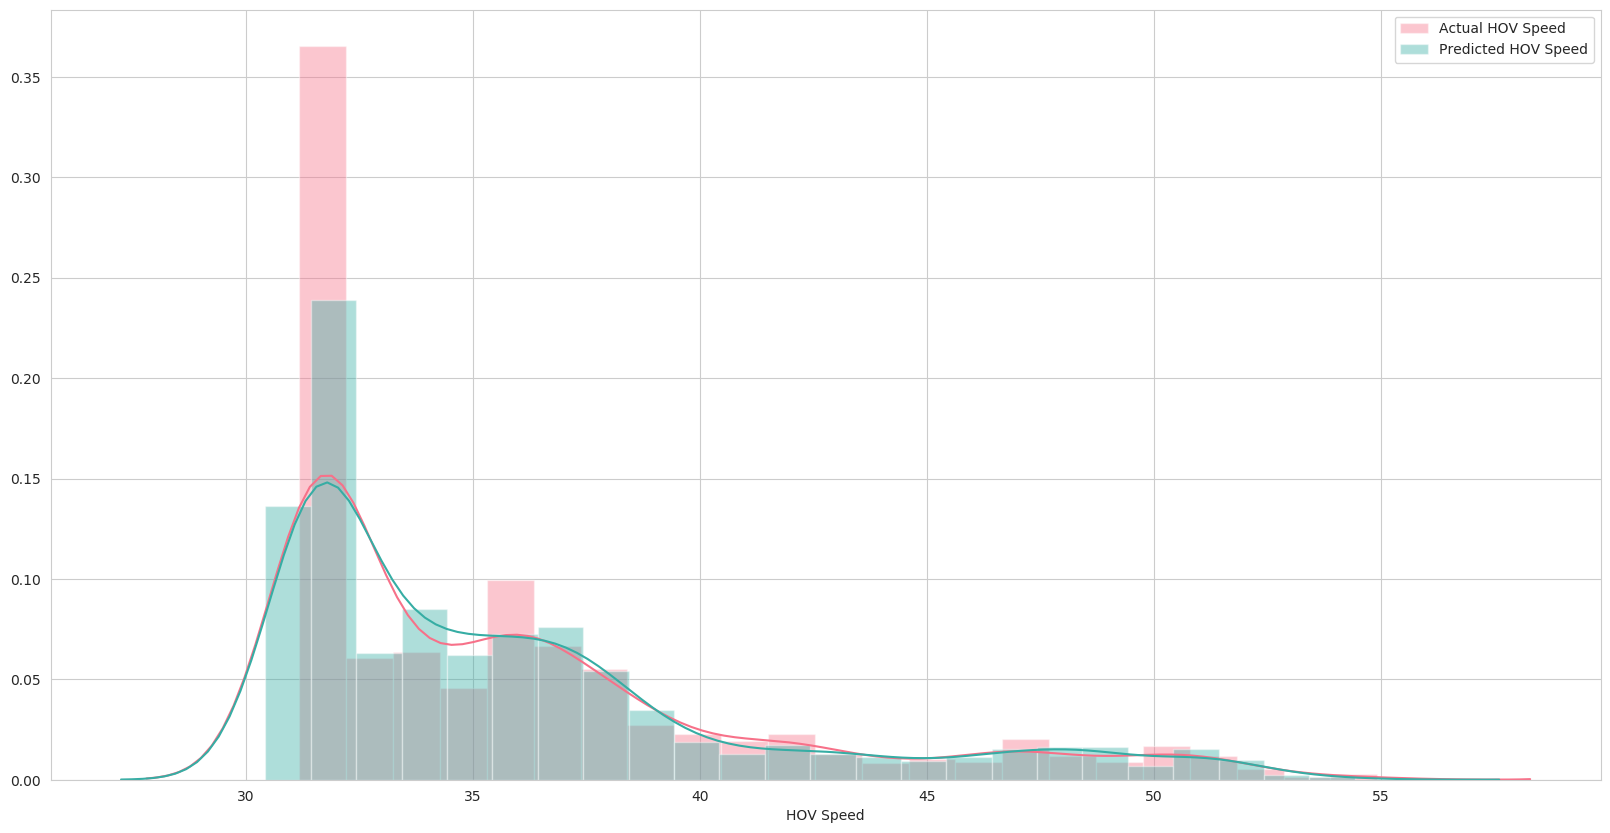

In [60]:
f, ax = plt.subplots(figsize=(20, 10)) 
sns.distplot(y_test, hist=True, label="Actual HOV Speed")
sns.distplot(y_pred, hist=True, label="Predicted HOV Speed")
plt.xlabel("HOV Speed")
plt.legend()
plt.show()

#### RandomForest model prediction

In [61]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators=250, random_state=0)
regressor_rf.fit(x_train, y_train)
y_pred = regressor_rf.predict(x_test)
Accuracy_rf=r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy_rf)

 Accuracy of the model is 98.37


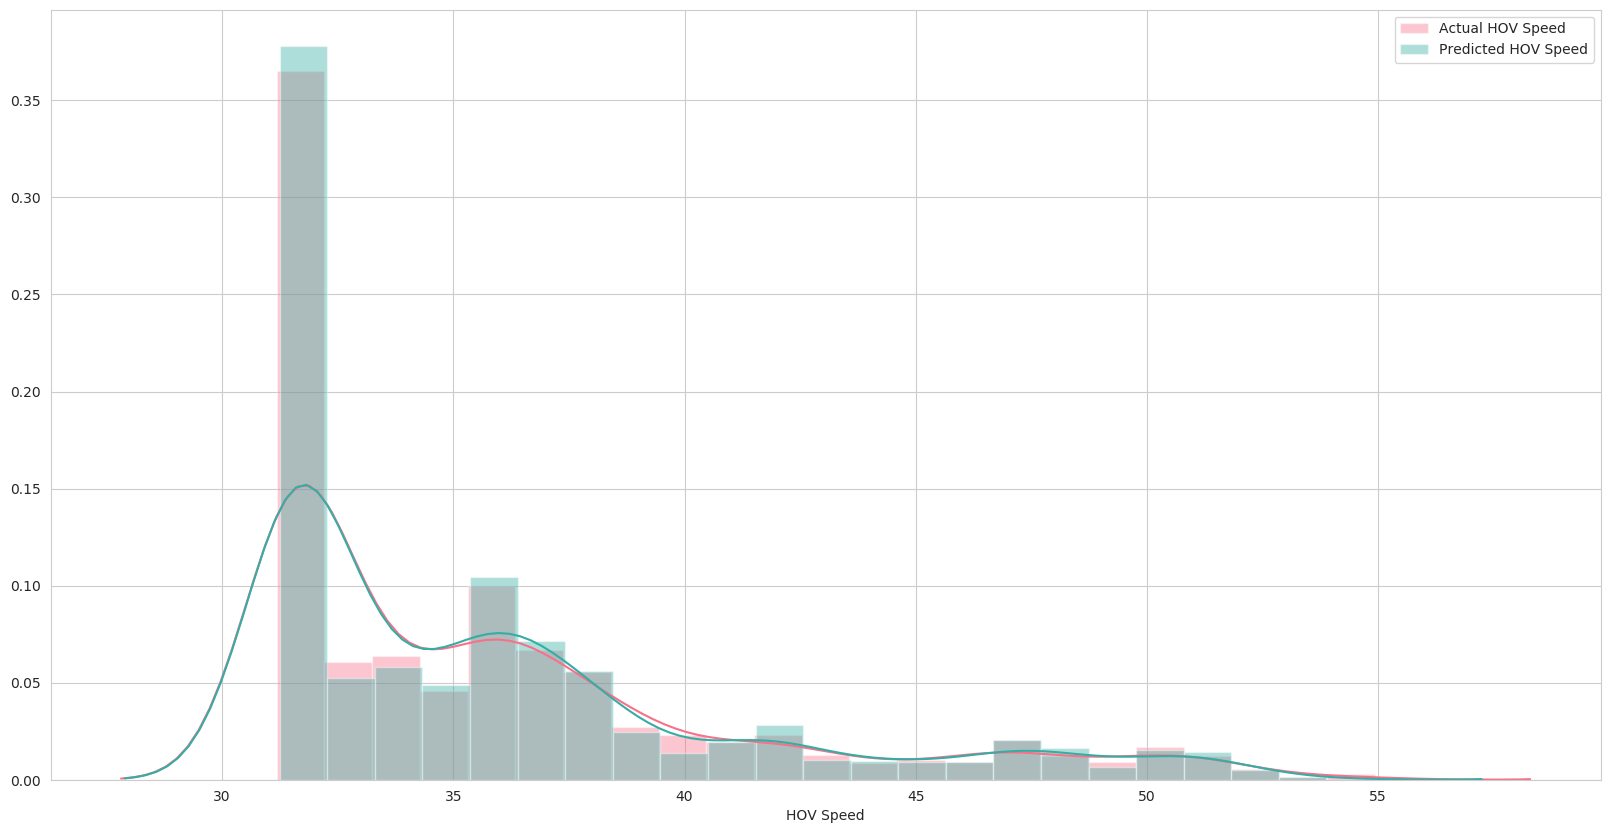

In [63]:
f, ax = plt.subplots(figsize=(20, 10)) 
sns.distplot(y_test, hist=True, label="Actual HOV Speed")
sns.distplot(y_pred, hist=True, label="Predicted HOV Speed")
plt.xlabel("HOV Speed")
plt.legend()
plt.show()